In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import tqdm
import torch_geometric
# set random seed 
np.random.seed(0)
torch.manual_seed(0)

In [2]:
mrna = '/home/dhakal/MoBI/data/ROSMAP/mrna.csv'

In [3]:
mrna_data_ori = pd.read_csv(mrna, index_col=0)
print(mrna_data_ori['Label'].value_counts())

# train_idx = mrna_data_ori['Split'] == 1.0
# test_idx = mrna_data_ori['Split'] == 0.0
# train_idx = train_idx.reshape(-1, 1)
# test_idx = test_idx.reshape(-1, 1)
# print(train_idx.shape, test_idx.shape)
y = mrna_data_ori['Label'].values
y = torch.tensor(y,dtype = torch.int64)
print(type(y))
#drop the columns Split and label
mrna_data = mrna_data_ori.drop(columns=['Split', 'Label'])
print(mrna_data.shape)
# print(y)

Label
1.0    182
0.0    169
Name: count, dtype: int64
<class 'torch.Tensor'>
(351, 200)


In [4]:
mrna_data_ori.head()

,hsa-let-7b,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-miR-1,hsa-miR-9,hsa-miR-10a,hsa-miR-10b,hsa-miR-15a,...,hcmv-miR-UL70-3p,hsv1-miR-H1,hsv1-miR-H3,hsv1-miR-H8,kshv-miR-K12-2,kshv-miR-K12-4-5p,kshv-miR-K12-9,mcv-miR-M1-5p,Label,Split
1,0.814405,0.737390,0.750965,0.826721,0.732031,0.509505,0.941783,0.383358,0.237087,0.689845,...,0.269750,0.197881,0.201138,0.224232,0.225317,0.315773,0.337299,0.275999,0.0,1.0
2,0.833053,0.745852,0.784690,0.833627,0.748797,0.554802,0.939369,0.405352,0.302349,0.677308,...,0.269379,0.222585,0.247331,0.176573,0.163122,0.250090,0.365844,0.331535,1.0,1.0
3,0.783300,0.729652,0.726530,0.832673,0.718069,0.444093,0.945906,0.346858,0.272595,0.686201,...,0.315306,0.263122,0.269576,0.340817,0.252720,0.356404,0.393057,0.302595,1.0,1.0
4,0.806268,0.726243,0.737167,0.838364,0.747425,0.530010,0.951981,0.344363,0.287244,0.709395,...,0.274718,0.240122,0.210502,0.244531,0.277194,0.336700,0.344629,0.297727,0.0,1.0
5,0.803373,0.739387,0.752465,0.821804,0.715556,0.482546,0.927272,0.350344,0.243749,0.673377,...,0.270051,0.170695,0.247333,0.248524,0.217929,0.242820,0.346970,0.381820,0.0,1.0


In [5]:
train_test = mrna_data_ori['Split'].values
train_idx = train_test == 1.0
test_idx = train_test == 0.0

In [6]:
def cal_co_expression_similarity(data):
    corr_matrix = np.abs(np.corrcoef(data))
    co_expression_similarity = np.abs(corr_matrix)
    return co_expression_similarity

In [7]:
cal_co_expression_similarity(mrna_data.T).shape

(200, 200)

In [8]:
def calculate_unweighted_adjacency(expression_profiles, threshold):
    # Calculate pairwise correlation coefficients
    correlation_matrix = torch.abs(torch.corrcoef(expression_profiles))
    
    # Apply hard thresholding
    adjacency_matrix = torch.where(correlation_matrix > threshold, torch.tensor(1), torch.tensor(0))
    
    return adjacency_matrix

In [9]:
def calculate_weighted_adjacency(expression_profiles, beta):
    # Calculate pairwise correlation coefficients
    correlation_matrix = torch.corrcoef(expression_profiles)
    
    # Apply weighted transformation
    adjacency_matrix = correlation_matrix ** beta
    
    return adjacency_matrix

In [10]:
threshold = 0.2
beta = 6
mrna_data_tensor = torch.tensor(mrna_data.values.T, dtype=torch.float32)
expression_similarity = cal_co_expression_similarity(mrna_data.T)
expression_similarity = torch.tensor(expression_similarity, dtype=torch.float32)

print("Expression similarity matrix:")
print(expression_similarity.shape)

unweighted_adjacency = calculate_unweighted_adjacency(expression_similarity, threshold)
weighted_adjacency = calculate_weighted_adjacency(expression_similarity, beta)

print("Unweighted adjacency matrix:")
print(unweighted_adjacency.shape)

print("\nWeighted adjacency matrix:")
print(weighted_adjacency.shape)


# print(unweighted_adjacency.min(), unweighted_adjacency.max())

Expression similarity matrix:
torch.Size([200, 200])
Unweighted adjacency matrix:
torch.Size([200, 200])

Weighted adjacency matrix:
torch.Size([200, 200])


In [11]:
unweighted_adjacency_tensor = torch.tensor(unweighted_adjacency, dtype=torch.long)
weighted_adjacency_tensor = torch.tensor(weighted_adjacency, dtype=torch.long)
print(unweighted_adjacency_tensor.shape)
print(weighted_adjacency_tensor.shape)

edge_index_unweighted = torch.nonzero(unweighted_adjacency_tensor, as_tuple=False)
edge_index_weighted = torch.nonzero(weighted_adjacency_tensor, as_tuple=False)

print(edge_index_unweighted.shape)
print(edge_index_weighted.shape)


data_unweighted = Data(x = mrna_data_tensor.T, edge_index = edge_index_unweighted.T, y = y)
data_unweighted.train_mask = torch.tensor(train_idx, dtype=torch.bool)
data_unweighted.test_mask = torch.tensor(test_idx, dtype=torch.bool)
data_weighted = Data(x=mrna_data_tensor.T, edge_index=edge_index_weighted.T, y=y)
data_weighted.train_mask = torch.tensor(train_idx, dtype=torch.bool)
data_weighted.test_mask = torch.tensor(test_idx, dtype=torch.bool)

# print(data_unweighted)
# print(data_weighted)

torch.Size([200, 200])
torch.Size([200, 200])
torch.Size([13004, 2])
torch.Size([162, 2])


/tmp/ipykernel_31400/3108664384.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unweighted_adjacency_tensor = torch.tensor(unweighted_adjacency, dtype=torch.long)
/tmp/ipykernel_31400/3108664384.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weighted_adjacency_tensor = torch.tensor(weighted_adjacency, dtype=torch.long)


In [12]:
data_weighted, data_unweighted

(Data(x=[351, 200], edge_index=[2, 162], y=[351], train_mask=[351], test_mask=[351]),
 Data(x=[351, 200], edge_index=[2, 13004], y=[351], train_mask=[351], test_mask=[351]))

In [13]:
np.unique(np.array(data_unweighted.y))

array([0, 1])

In [14]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define the dimensions of the GNN model
input_dim = mrna_data_tensor.T.shape[1]  # Number of input features
hidden_dim = 64  # Number of hidden units
output_dim = 2  # Number of output classes

# Create an instance of the GNN model
model = GNN(input_dim, hidden_dim, output_dim)

# Move the model to the appropriate device (e.g., GPU if available)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# Print the model architecture
print(model)


GNN(
  (conv1): GCNConv(200, 64)
  (conv2): GCNConv(64, 2)
)


In [17]:
type(data_unweighted)

torch_geometric.data.data.Data

In [26]:
data_unweighted.x.shape, data_unweighted.edge_index.shape, data_unweighted.y.shape

(torch.Size([351, 200]), torch.Size([2, 13004]), torch.Size([351]))

In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
def train(curr_data):
    model.train()
    optimizer.zero_grad()
    output = model(curr_data)
    loss = criterion(output[curr_data.train_mask], curr_data.y[curr_data.train_mask])
    loss.backward()
    optimizer.step()

In [55]:
def test(test_data):
    model.eval()
    output = model(test_data)
    pred = output.argmax(dim=1)
    correct = pred[test_data.test_mask].eq(test_data.y[test_data.test_mask]).sum().item()
    total = test_data.test_mask.sum().item()
    return correct / total

In [56]:
test_acc = 0
pbar = tqdm.tqdm(range(200))
for epoch in pbar:  # Assuming 50 epochs
    train(data_unweighted)
    test_acc = test(data_unweighted)
    pbar.set_description("Test accuracy: %.3f" % test_acc)
    # print(f'Epoch: {epoch+1}, Test Acc: {test_acc:.4f}')

Test accuracy: 0.538: 100%|██████████| 200/200 [00:03<00:00, 60.49it/s]


In [57]:
test_acc = test(data_unweighted)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5377


In [58]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

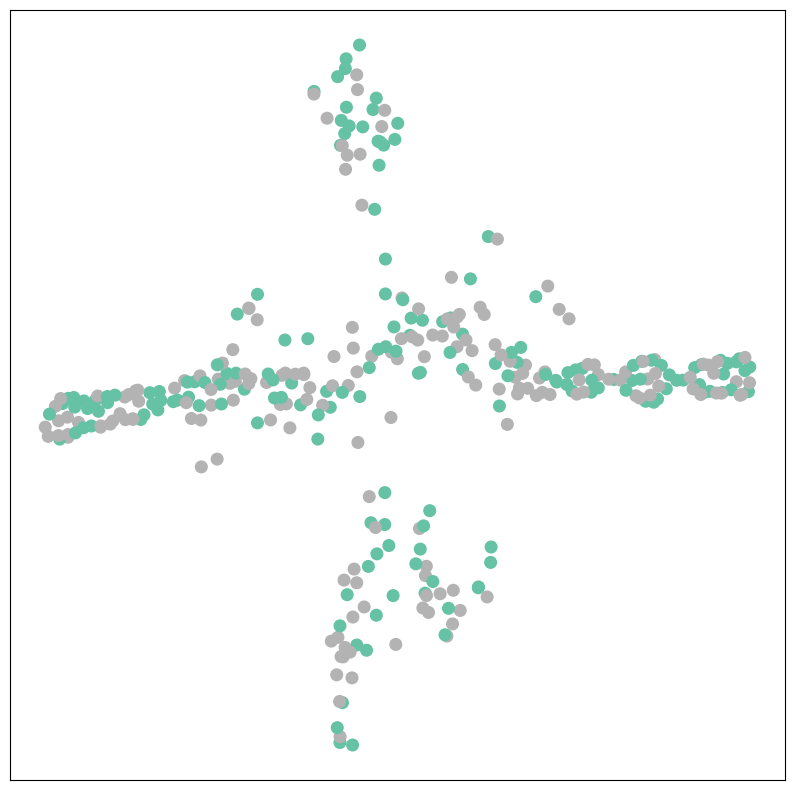

In [52]:
out = model(data_unweighted)
visualize(out, color=data_unweighted.y)